In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import random
import shutil
import tensorflow.contrib.learn as tflearn
import tensorflow.contrib.layers as tflayers
from tensorflow.contrib.learn.python.learn import learn_runner
import tensorflow.contrib.metrics as metrics
import tensorflow.contrib.rnn as rnn

/home/cvdev/tf/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# data 1 :随机数据
# random.seed(111)
# rng = pd.date_range(start='2000', periods=809, freq='M')
# ts = pd.Series(np.random.uniform(-10, 10, size=len(rng)), rng).cumsum()
# ts.plot(c='b', title='Example Time Series')
# plt.show()
# ts.head(10)

### Generating sample data

In [3]:
def generate_data(num_periods = 120, f_horizon = 4, samples = 10020):
    # data  : t*sin(t)/3 + 2*sin(5*t)
    t = np.linspace(0,100,num=samples)
    ts = t*np.sin(t)/3 + 2.*np.sin(5.*t)
    plt.plot(t,ts);
    
    TS = np.array(ts)

    x_data = TS[:(len(TS)-(len(TS) % num_periods))]
    y_data = TS[f_horizon : (len(TS)-(len(TS) % num_periods)+f_horizon)]
    print("length of training data x : ", x_data.shape)
    print("length of training data y : ", y_data.shape)

    x_batches = x_data.reshape(-1,num_periods,1)
    y_batches = y_data.reshape(-1,num_periods,1)

    print("training data x shape : ", x_batches.shape)
    
    test_x_setup = TS[-(num_periods + f_horizon):]
    testX = test_x_setup[:num_periods].reshape(-1,num_periods,1) 
    testY = TS[-(num_periods):].reshape(-1,num_periods,1)
    
    return x_batches, y_batches, testX, testY

### RNN model

In [33]:
def rnn_model(X_train, y_train, X_test, Y_test, cell="BasicRNNCell", 
              learning_rate=0.001, epochs=500, print_every=100, 
              inputs=1, outputs=1, hidden=100, num_periods=20):
    '''
    X_tarin : x traning data.
    y_train : y training data.
    X_test : x data for prediction.
    Y_test : ground truth of y data when doing prediction.
    cell : which kind of rnn cell to use, "BasicRNNCell" for BasicRNNCell, "LSTMCell" for LSTMCell
    learning_rate
    inputs : input_shape
    outputs : output_shape
    hidden : number of hidden units
    num_periods : length of time sequences.
    '''
    tf.reset_default_graph()

    X = tf.placeholder(tf.float32, [None, num_periods, inputs])
    y = tf.placeholder(tf.float32, [None, num_periods, outputs])

    if cell == "BasicRNNCell" :
        basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=hidden, activation=tf.nn.relu)
    elif cell == "LSTMCell" :
        basic_cell = tf.contrib.rnn.LSTMCell(num_units=hidden, activation=tf.nn.relu)
    else :
        print("Cell model wrong.")
        return

    rnn_output, status = tf.nn.dynamic_rnn(basic_cell, X, dtype=tf.float32)

    stacked_rnn_output = tf.reshape(rnn_output, [-1, hidden])
    stacked_outputs = tf.layers.dense(stacked_rnn_output, outputs)
    outputs = tf.reshape(stacked_outputs, [-1, num_periods, outputs])

    loss = tf.reduce_sum(tf.square(outputs - y))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    losses = []
    with tf.Session() as sess:
        sess.run(init)
        for ep in range(epochs):
            _, loss_value = sess.run([training_op, loss], feed_dict={X:x_batches, y:y_batches})
            losses.append(loss_value)
            
            if ep % print_every == 0:
                mse = loss.eval(feed_dict={X:x_batches, y:y_batches})
                print(ep, "  MSE:", mse)

        y_pred = sess.run(outputs, feed_dict={X:X_test})
        # print(y_pred)

    plt.title("Forecast vs Actual", fontsize=14)
    plt.plot(pd.Series(np.ravel(Y_test)), 'bo', markersize=10, label="Actual")
    plt.plot(pd.Series(np.ravel(y_pred)), 'r.', markersize=10, label="Forecast")
    plt.legend(loc="upper left")
    plt.xlabel("Time Periods")

    return losses

In [56]:
def moving_f_horizons(f_horizons):
    '''
    Check the relationship between f_horizon and the behavior.
    Parameters must match.
    '''
    for f_horizon in f_horizons:    
        X_batches, y_batches, X_test, y_test = generate_data(num_periods = 120, f_horizon = f_horizon, samples = 10009)
        print(X_test.shape)
        print("f_horizon is %d." %f_horizon)
        losses = rnn_model(X_batches, y_batches, X_test, y_test, cell="BasicRNNCell", 
                  learning_rate=0.001, epochs=5000, print_every=100, 
                  inputs=1, outputs=1, hidden=100, num_periods=120)

length of training data x :  (9960,)
length of training data y :  (9960,)
training data x shape :  (83, 120, 1)
(1, 120, 1)
f_horizon is 1.
0   MSE: 2080868.0
100   MSE: 59662.9
200   MSE: 21974.836
300   MSE: 15269.787
400   MSE: 12142.6045
500   MSE: 10112.111
600   MSE: 8871.295
700   MSE: 8960.424
800   MSE: 8557.16
900   MSE: 10506.658
1000   MSE: 6978.046
1100   MSE: 6930.808
1200   MSE: 6523.792
1300   MSE: 6223.58
1400   MSE: 6279.207
1500   MSE: 6412.6846
1600   MSE: 5675.5215
1700   MSE: 9036.522
1800   MSE: 6214.885
1900   MSE: 7055.9155
2000   MSE: 60659.516
2100   MSE: 34048.305
2200   MSE: 8625.775
2300   MSE: 7739.459
2400   MSE: 8479.301
2500   MSE: 8275.545
2600   MSE: 6905.9185
2700   MSE: 6580.2773
2800   MSE: 6778.4536
2900   MSE: 6199.87
3000   MSE: 6370.404
3100   MSE: 8312.016
3200   MSE: 5931.9844
3300   MSE: 6086.3237
3400   MSE: 6708.457
3500   MSE: 5745.376
3600   MSE: 5931.0557
3700   MSE: 9220.558
3800   MSE: 5447.3745
3900   MSE: 5106.851
4000   MSE: 5066.

4000   MSE: 6003.977
4100   MSE: 5533.3604
4200   MSE: 6342.5557
4300   MSE: 5439.4756
4400   MSE: 5642.1113
4500   MSE: 5703.379
4600   MSE: 4975.002
4700   MSE: 5082.8784
4800   MSE: 5991.671
4900   MSE: 4798.7095


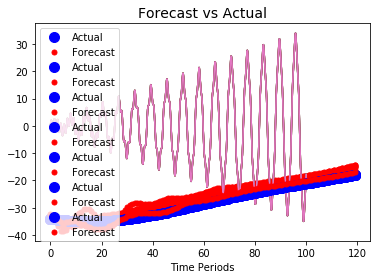

In [57]:
moving_f_horizons([1,2,3,4,5,8,10])

### f_horizon 即向前推测4个位置 x[a:b] -> x[a+4:b+4]

length of training data x :  (9960,)
length of training data y :  (9960,)
training data x shape :  (83, 120, 1)


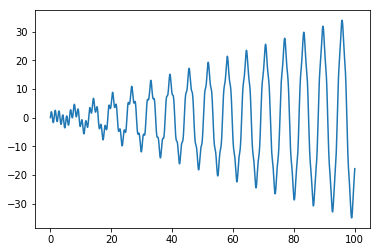

In [34]:
X_batches, y_batches, X_test, y_test = generate_data(num_periods = 120, f_horizon = 4, samples = 10020)

0   MSE: 1055469.1
100   MSE: 6447.548
200   MSE: 3368.9565
300   MSE: 1499.905
400   MSE: 435.25995


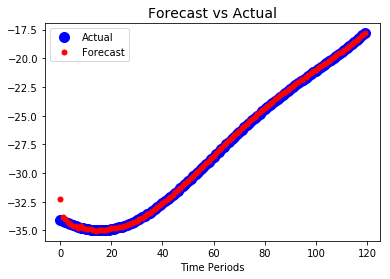

In [35]:
losses = rnn_model(X_batches, y_batches, X_test, y_test, cell="BasicRNNCell", 
              learning_rate=0.001, epochs=500, print_every=100, 
              inputs=1, outputs=1, hidden=100, num_periods=120)

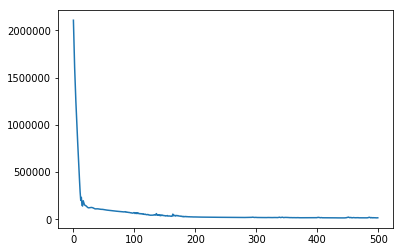

In [43]:
plt.plot(losses);

### f_horizon 即向前推测20个位置 x[a:b] -> x[a+20:b+20]

length of training data x :  (9960,)
length of training data y :  (9960,)
training data x shape :  (83, 120, 1)


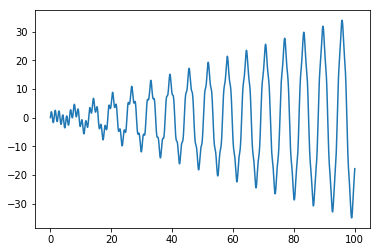

In [36]:
X_batches, y_batches, X_test, y_test = generate_data(num_periods = 120, f_horizon = 20, samples = 10020)

0   MSE: 1846016.2
100   MSE: 63572.906
200   MSE: 21648.402
300   MSE: 18228.098
400   MSE: 13437.545


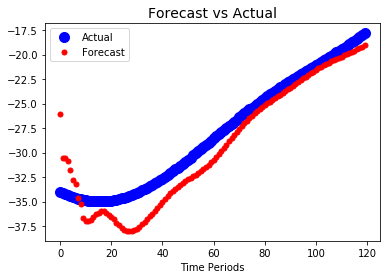

In [37]:
losses = rnn_model(X_batches, y_batches, X_test, y_test, cell="BasicRNNCell", 
              learning_rate=0.001, epochs=5000, print_every=100, 
              inputs=1, outputs=1, hidden=100, num_periods=120)

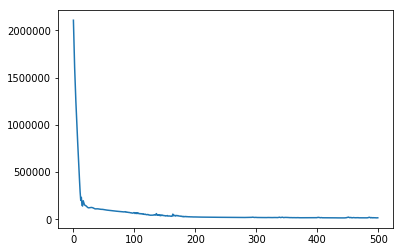

In [44]:
plt.plot(losses);

### f_horizon 即向前推测48个位置 x[a:b] -> x[a+48:b+48]

length of training data x :  (9960,)
length of training data y :  (9960,)
training data x shape :  (83, 120, 1)


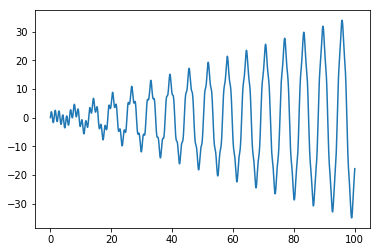

In [39]:
X_batches, y_batches, X_test, y_test = generate_data(num_periods = 120, f_horizon = 20, samples = 10020)

0   MSE: 1408623.0
100   MSE: 59942.516
200   MSE: 22920.168
300   MSE: 23129.318
400   MSE: 13912.915


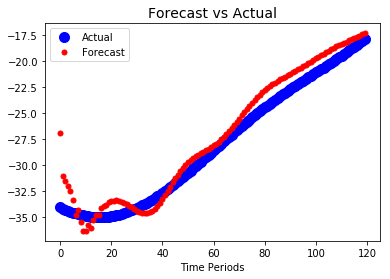

In [46]:
losses = rnn_model(X_batches, y_batches, X_test, y_test, cell="BasicRNNCell", 
              learning_rate=0.001, epochs=500, print_every=100, 
              inputs=1, outputs=1, hidden=100, num_periods=120)

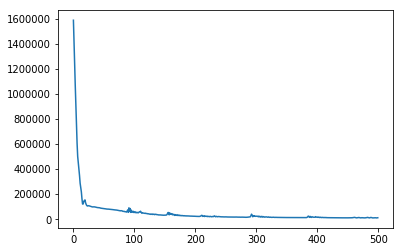

In [47]:
plt.plot(losses);